# Glucose Data Science
---
Goal: The goal of this experiment is to see if it is possible to predict which days I have exercised based on the days
blood glucose readings.
Stretch Goal: Predict the type of excercise.

### Technology:
- Apple HealthKit
- Dexcom Continuous Glucose Monitor
- Datascience

### High Level Objectives:
- Gather Data
- Clean Up Data
- Inspect Data
- ML with Data

### Background Information:
 I have __Type 1 Diabetes__ which is an auto-immune disease that causes my body to attack the insulin
 producing cells in my pancreas. Insulin is what helps your body use the energy (glucose) in the food you eat. To manage
 this disease I use some extremely cool pieces of technology. One is a continuous glucose monitor called a __Dexcom__
 CGM. I wear this cgm on my body, and it measures the amount of glucose in my interstitial fluid ( also known as the
 fluid between cells) every 5 minutes. That data is then sent to my phone ( even allowing me to view my real time
 glucose on my Apple Watch! ) as well as my insulin pump. This data, as well as other information is used to help manage
 my Diabetes.

 It has been my personal experience, that when I exercise, I tend to have higher insulin sensitivity, usually meaning
 better blood glucose numbers throughout the day. Your blood glucose is what your body automatically regulates on its
 own with insulin, but must be done manually as a type 1 diabetic.

 The goal of this exercise is to see if I can pull that correlation out with data, and possibly see if I can use a
 Machine Learning Model to predict which days I exercised, based only off my glucose data.

# Gather Data
---
The source of the excercise data will be apple healthkit. Apple Healthkit automatically has my excercise data in it from when I
track workouts. It also can be configured to sync with the Dexcom iOS app. So now lets see if we can download and load
that data.

## Export data from phone:
- Navigate to health app
- click on your profile icon
- scroll to bottom and click export all health data
- this may take a few minutes
- donwload zip
- expand zip
- this data is pretty sensitive, so don't commit it to git!


In [80]:
import sys
from os import path
print("The version of python is: ", sys.version)

The version of python is:  3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


# Let's import this data into pandas

In [81]:
import pandas as pd
input_path = './apple_health_export/export.xml'
debug_data = False

# Don't do this conversion if we already created the csv cache
if not path.isfile('./csv_cache/df.csv'):
    import xmltodict
    with open(input_path, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    # available health records
    # thanks to this article for explaining:
    #   https://medium.com/better-programming/analyze-your-icloud-health-data-with-pandas-dd5e963e902f
    records_list = input_data['HealthData']['Record']
    df = pd.DataFrame(records_list)
    # Lets cache with df as a csv, because the load process takes forever
    df.to_csv('./csv_cache/df.csv',header=False, index=False)
else:
    # We can just load the cache file into the df
    # FYI TOTAL number of rows: 3967494
    if debug_data:
        # the data set is over 1gb, and my computer is struggling working with it, this should work around that issue
        # this will just give us the last 200000 rows
        df = pd.read_csv('./csv_cache/df.csv',
                         nrows=1000000,
                         skiprows=2967494,
                         names=['@type',
                                '@sourceName',
                                '@unit',
                                '@creationDate',
                                '@startDate',
                                '@endDate',
                                '@value',
                                'MetadataEntry',
                                '@sourceVersion',
                                '@device',
                                'HeartRateVariabilityMetaDataList'])
    else:
        # @type,@sourceName,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@sourceVersion,@device,HeartRateVariabilityMetadataList
        df = pd.read_csv('./csv_cache/df.csv',
                         names=['@type',
                                '@sourceName',
                                '@unit',
                                '@creationDate',
                                '@startDate',
                                '@endDate',
                                '@value',
                                'MetadataEntry',
                                '@sourceVersion',
                                '@device',
                                'HeartRateVariabilityMetaDataList'])

/Users/ddiaz/src/glucose-datascience/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
df.columns

Index(['@type', '@sourceName', '@unit', '@creationDate', '@startDate',
       '@endDate', '@value', 'MetadataEntry', '@sourceVersion', '@device',
       'HeartRateVariabilityMetaDataList'],
      dtype='object')

In [83]:
# Show All data types
df['@type'].unique()

# show all source types
# df['@device'].unique()

# (Optional) Limit Data to phone
# df = df[df['@sourceName'].str.contains('iPhone')]

array(['HKQuantityTypeIdentifierBloodGlucose',
       'HKQuantityTypeIdentifierBodyMassIndex',
       'HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierBodyFatPercentage',
       'HKQuantityTypeIdentifierLeanBodyMass',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierDistanceCycling',
       'HKQuantityTypeIdentifierDistanceSwimming',
       'HKQuantityTypeIdentifierSwimmingStrokeCount',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierVO2Max',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierEnvironmentalAudioExposure',
     

OK, so based off my initial analysis, workouts are not located in this dataset, only glucose and other health data.
I need to see how i can mege the workout data sets against this one cause thats what i want to test.
but in the mean time, lets at least pull out some glucose data

Apple docs ref: https://developer.apple.com/documentation/healthkit/hkobjecttype

In [84]:
glucose_values = df[df['@type'] == 'HKQuantityTypeIdentifierBloodGlucose']

In [85]:
# 474135 - 474305

last_day_bg = df[-200:]


<AxesSubplot:>

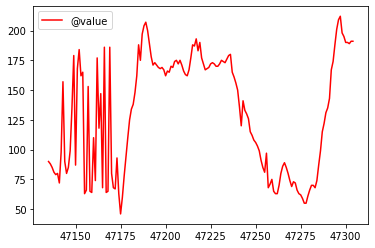

In [89]:
import matplotlib.pyplot as plt
last_day_bg.plot(kind='line',y='@value',color='red')

Hmm the range looks right, but the variablility looks wrong. may need to filter on device if there are conflicting devices

